# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import CLASSIFICATION, REGRESSION
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

/Users/jhkwakkel/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/jhkwakkel/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

model = Model('Python', function=PredPrey)
model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                       RealParameter('predator_efficiency', 0.001, 0.004),
                       RealParameter('predator_loss_rate', 0.04, 0.08)] 
model.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('predators'),
                  TimeSeriesOutcome('prey')]

# OLS

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment

In [3]:
from ema_workbench import MultiprocessingEvaluator

n_scenarios = 1000

# NOTE:: if you want to run this on windows, move 
# the PredPrey function to a .py file and import it into 
# the notebook, analogous to the lake problem assignment
with MultiprocessingEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios)


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [4]:
prey_final = outcomes['prey'][:,0,-1]
prey_mean = np.mean(outcomes['prey'][:,0,:],axis=1)
prey_std = np.std(outcomes['prey'][:,0,:],axis=1)

In [5]:
import statsmodels.api as sm

X = pd.DataFrame(experiments).drop(['model','policy'], inplace=False, axis=1)
X_0 = sm.add_constant(X)

est = sm.OLS(prey_final, X_0.astype(float)).fit()
print(est.summary())
print(est.params)

/Users/jhkwakkel/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/jhkwakkel/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     118.1
Date:                Wed, 09 May 2018   Prob (F-statistic):           4.32e-98
Time:                        20:05:57   Log-Likelihood:                -4225.0
No. Observations:                1000   AIC:                             8462.
Df Residuals:                     994   BIC:                             8491.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  33.5080    

In this case, the linear regression clearly isn't capturing most of the output variance (as shown by the $R^2$ value). We can therefore use the Sobol results with the SALib analysis functions for a more comprehensive analysis. We first use the get_SALib_problem function to convert the model's uncertainties to a dictionary which is compatible with SALib. This includes the names and bounds of the uncertainties.

# Sobol

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

In [6]:
sobol_problem = problem = get_SALib_problem(model.uncertainties)

In [12]:
n_scenarios = 50

with MultiprocessingEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios, uncertainty_sampling=SOBOL)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 500 scenarios * 1 policies * 1 model(s) = 500 experiments
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [13]:
prey_final = outcomes['prey'][:,0,-1]

scores = sobol.analyze(problem, prey_final, calc_second_order=True, print_to_console=True)

## TODO make as nice dataframes


Parameter S1 S1_conf ST ST_conf
predation_rate 0.093433 0.117929 0.127158 0.083625
predator_efficiency 0.467832 0.368204 0.861776 0.403584
predator_loss_rate 0.106056 0.215457 0.586328 0.295402
prey_birth_rate 0.067219 0.311829 0.509988 0.241470

Parameter_1 Parameter_2 S2 S2_conf
predation_rate predator_efficiency -0.056636 0.154674
predation_rate predator_loss_rate -0.096614 0.131621
predation_rate prey_birth_rate -0.164523 0.132321
predator_efficiency predator_loss_rate -0.087430 0.379419
predator_efficiency prey_birth_rate -0.017606 0.506305
predator_loss_rate prey_birth_rate 0.060809 0.304166


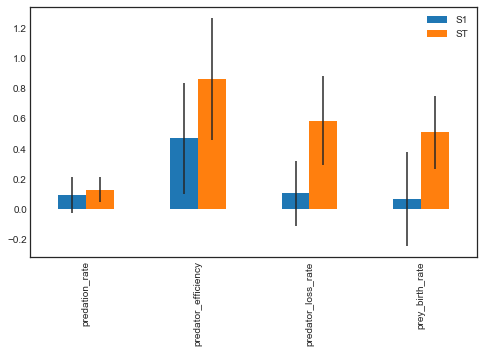

In [14]:
def plot_scores(scores):
    scores_filtered = {k:scores[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    return fig

plot_scores(scores)
plt.show()

In [15]:
n_scenarios = 250

with MultiprocessingEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios, uncertainty_sampling=SOBOL)

prey_final = outcomes['prey'][:,0,-1]
scores = sobol.analyze(problem, prey_final, calc_second_order=True, print_to_console=True)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 2500 scenarios * 1 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Parameter S1 S1_conf ST ST_conf
predation_rate 0.054258 0.054969 0.123294 0.040792
predator_efficiency 0.279763 0.159220 0.852120 0.172941
predator_loss_rate 0.017445 0.125612 0.606673 0.112879
prey_birth_rate -0.044853 0.119422 0.565059 0.098736

Parameter_1 Parameter_2 S2 S2_conf
predation_rate predator_efficiency -0.016744 0.095818
predation_rate predator_loss_rate -0.034967 0.083781
predation_rate prey_birth_rate -0.058457 0.080233
predator_efficiency predator_loss_rate 0.067267 0.151596
predator_efficiency prey_birth_rate 0.095902 0.175363
predator_loss_rate prey_birth_rate 0.160034 0.151433


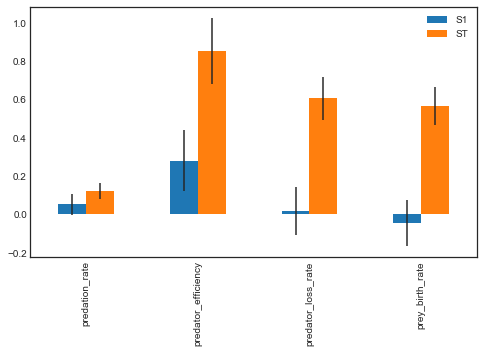

In [16]:
plot_scores(scores)
plt.show()

In [17]:
n_scenarios = 1000

with MultiprocessingEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios, uncertainty_sampling=SOBOL)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [18]:
prey_final = outcomes['prey'][:,0,-1]

scores = sobol.analyze(problem, prey_final, calc_second_order=True, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
predation_rate -0.002546 0.027140 0.132785 0.025104
predator_efficiency 0.407665 0.079306 0.809377 0.090141
predator_loss_rate 0.079809 0.058879 0.585974 0.060047
prey_birth_rate 0.030426 0.058248 0.511565 0.055079

Parameter_1 Parameter_2 S2 S2_conf
predation_rate predator_efficiency 0.009710 0.046327
predation_rate predator_loss_rate 0.001582 0.041694
predation_rate prey_birth_rate 0.009356 0.039888
predator_efficiency predator_loss_rate -0.063009 0.094588
predator_efficiency prey_birth_rate -0.049566 0.091511
predator_loss_rate prey_birth_rate 0.064763 0.096166


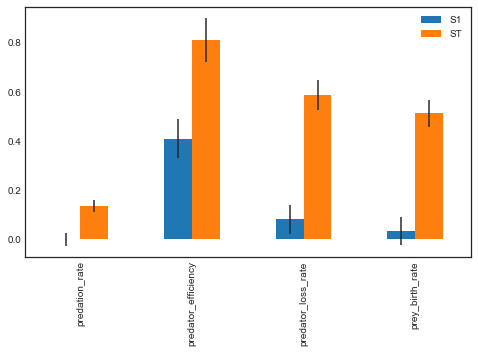

In [19]:
plot_scores(scores)
plt.show()

In [20]:
# we will reuse this below
sobol_scores = pd.DataFrame(list(zip(sobol_problem['names'], scores['ST'])))


* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices?

In [21]:
n_scenarios = 1000

# NOTE:: if you want to run this on windows, move 
# the PredPrey function to a .py file and import it into 
# the notebook, analogous to the lake problem assignment
with MultiprocessingEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [22]:
from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes['prey'][:,0,-1]

scores, _ = feature_scoring.get_rf_feature_scores(x, y, feature_scoring.REGRESSION, nr_trees=100, max_features=0.6)

In [23]:
sobol = sobol_scores.set_index(0)
sobol.columns = ['sobol']

extra_trees = scores.set_index(0)
extra_trees.columns = ['extra_trees']
combined = pd.merge(sobol, extra_trees, left_index=True, right_index=True)

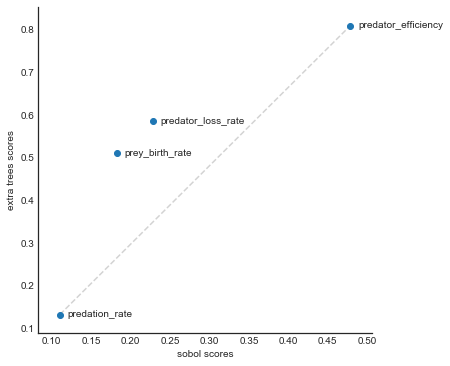

In [39]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(combined.extra_trees, combined.sobol)
ax.set_xlabel('sobol scores')
ax.set_ylabel('extra trees scores')

# let's name the points in the scatter plot
for name, row in combined.iterrows():
    # we need a small offset on the x-axis to avoid
    # having the name starting in the dot
    ax.text(row.extra_trees+0.01, row.sobol, name, 
            va='center', ha='left')

# add a light grey diagonal line
minima = combined.min()
maxima = combined.max()
ax.plot([minima.extra_trees, maxima.extra_trees],
        [minima.sobol, maxima.sobol], ls='--', c='lightgrey',
        zorder=0)
    
sns.despine()
plt.show()
